# Análisis de Regresión Lineal Múltiple sobre sales
## Objetivo del análisis

El propósito de este análisis es aplicar un modelo de regresión lineal múltiple para evaluar si las variables disponibles permiten explicar y/o predecir la variable dependiente sales (ventas).
Aunque los resultados del ANOVA indicaron que no existen diferencias significativas en las medias de ventas entre categorías de productos, este nuevo enfoque busca determinar si existe alguna relación lineal conjunta entre múltiples variables independientes y las ventas.



## DEPENDENCIAS

Se importan las librerías necesarias para el análisis, incluyendo herramientas para manipulación de datos (`pandas`, `numpy`), visualización (`matplotlib`, `seaborn`), y modelado estadístico y preprocesamiento (`sklearn`, `statsmodels`, `scipy`, `pingouin`). También se incluye `gdown` para descargar el archivo de datos.

In [ ]:
%pip install pingouin
%pip install gdown

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.4/204.4 kB 4.7 MB/s eta 0:00:00


In [ ]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np
import gdown
# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocesado y modelado
# ==============================================================================
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
from scipy import stats

# Configuración matplotlib
# ==============================================================================
plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 10, 'lines.linewidth': 1.5})

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

## CARGA DEL ARCHIVO ARCHIVO Y DEFINICION DEL DATAFRAME

El conjunto de datos, almacenado en un archivo CSV en Google Drive, se descarga y se carga en un DataFrame de pandas para su manipulación y análisis. Se visualizan las primeras filas para confirmar la carga correcta.

In [ ]:
url = "https://drive.google.com/uc?id=1zkT0jGxmGFeSkksikmF9D1qHBL8QBDZa"
output = "pet_store_records_2020.csv"
gdown.download(url, output, quiet=False)
df = pd.read_csv(output, delimiter=',')
df.head()

Downloading...
From: https://drive.google.com/uc?id=1zkT0jGxmGFeSkksikmF9D1qHBL8QBDZa
To: /content/pet_store_records_2020.csv
100%|██████████| 48.0k/48.0k [00:00<00:00, 13.1MB/s]


,product_id,product_category,sales,price,VAP,vendor_id,country,pet_size,pet_type,rating,re_buy
0,5040,Equipment,123,7293,0,VC_1605,Vietnam,small,fish,7,1
1,4567,Toys,61,9304,1,VC_1132,India,small,cat,10,0
2,4237,Toys,218,8180,0,VC_802,India,small,hamster,6,0
3,4364,Snack,69,18559,1,VC_929,India,large,dog,1,1
4,4184,Supplements,138,10283,1,VC_749,India,large,dog,10,0


## Transformacion de variables categoricas a numericas

Para preparar los datos para el modelo de regresión, las variables categóricas como la categoría de producto, país, tamaño y tipo de mascota se transforman en variables numéricas utilizando la técnica de One-Hot Encoding. Esto crea columnas binarias para cada categoría, permitiendo su inclusión en el modelo lineal. Se elimina una columna por cada variable original para evitar multicolinealidad.

In [ ]:
datos = pd.read_csv('pet_store_records_2020.csv')

In [ ]:
# Transformar todas las categóricas en dummies
categorical_cols = ['product_category', 'country', 'pet_size', 'pet_type']
# Transformar a dummies
datos_dummy = pd.get_dummies(datos, columns=categorical_cols, drop_first=True)

# Mostrar el resultado
print(datos_dummy.head())

   product_id  sales  price  VAP vendor_id  rating  re_buy  \
0        5040    123   7293    0   VC_1605       7       1   
1        4567     61   9304    1   VC_1132      10       0   
2        4237    218   8180    0    VC_802       6       0   
3        4364     69  18559    1    VC_929       1       1   
4        4184    138  10283    1    VC_749      10       0   

   product_category_Bedding  product_category_Clothes  \
0                     False                     False   
1                     False                     False   
2                     False                     False   
3                     False                     False   
4                     False                     False   

   product_category_Equipment  ...  country_Vietnam  pet_size_extra_small  \
0                        True  ...             True                 False   
1                       False  ...            False                 False   
2                       False  ...            False  


## Relación entre variables
El primer paso a la hora de establecer un modelo lineal múltiple es estudiar la relación que existe entre variables. Esta información es crítica a la hora de identificar cuáles pueden ser los mejores predictores para el modelo, y para detectar colinealidad entre predictores. A modo complementario, es recomendable representar la distribución de cada variable.

## Correlación entre variables numéricas
Se analiza la relación lineal entre las variables numéricas del conjunto de datos.

Se calcula y visualiza la matriz de correlación para entender cómo se relacionan entre sí las variables numéricas como sales, price, VAP, rating y re_buy. Esto ayuda a identificar posibles predictores para el modelo de regresión y detectar colinealidad.

La correlación mide la fuerza y dirección de una relación lineal entre dos variables. En un modelo de regresión, es útil conocer estas relaciones para seleccionar variables y evitar problemas de multicolinealidad.

In [ ]:
# Correlación entre columnas numéricas
# ==============================================================================
def tidy_corr_matrix(corr_mat):
    '''
    Función para convertir una matriz de correlación de pandas en formato tidy
    '''
    corr_mat = corr_mat.stack().reset_index()
    corr_mat.columns = ['variable_1','variable_2','r']
    corr_mat = corr_mat.loc[corr_mat['variable_1'] != corr_mat['variable_2'], :]
    corr_mat['abs_r'] = np.abs(corr_mat['r'])
    corr_mat = corr_mat.sort_values('abs_r', ascending=False)

    return corr_mat

corr_matrix = datos.select_dtypes(include=['float64', 'int']).corr(method='pearson')
tidy_corr_matrix(corr_matrix).head(10)

,variable_1,variable_2,r,abs_r
29,rating,re_buy,-0.087367,0.087367
34,re_buy,rating,-0.087367,0.087367
32,re_buy,price,0.068537,0.068537
17,price,re_buy,0.068537,0.068537
15,price,VAP,0.063942,0.063942
20,VAP,price,0.063942,0.063942
26,rating,price,0.054253,0.054253
16,price,rating,0.054253,0.054253
33,re_buy,VAP,0.047595,0.047595
23,VAP,re_buy,0.047595,0.047595


## Heatmap de la matriz de correlaciones

Se realiza una matriz de la correlación calculada anteriormente, con el fin de representar visualmente las correlaciones entre las variables numéricas. Los colores más intensos (hacia rojo o azul) indican correlaciones más fuertes (positivas o negativas), mientras que los colores más claros (hacia blanco) indican correlaciones débiles. Los valores numéricos en las celdas confirman el coeficiente de correlación.

Un heatmap facilita la rápida identificación de pares de variables con altas correlaciones, lo cual es importante para la selección de variables y la detección de multicolinealidad.

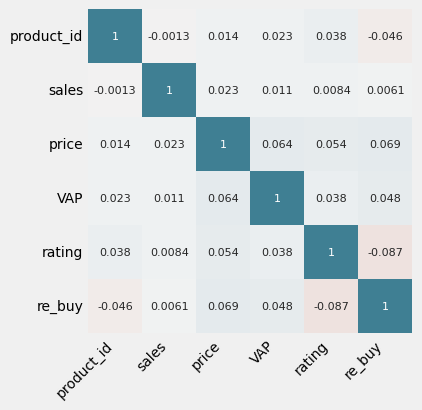

In [ ]:
# Heatmap matriz de correlaciones
# ==============================================================================
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))
sns.heatmap(
    corr_matrix,
    annot     = True,
    cbar      = False,
    annot_kws = {"size": 8},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = sns.diverging_palette(20, 220, n=200),
    square    = True,
    ax        = ax
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right',
)

ax.tick_params(labelsize = 10)

**Resultados y Conclusión:**

El análisis de la matriz de correlación y el heatmap muestra que las correlaciones lineales entre las variables numéricas (`sales`, `price`, `VAP`, `rating`, `re_buy`) son generalmente bajas, con coeficientes cercanos a cero. Esto sugiere que, individualmente, estas variables numéricas tienen una relación lineal débil con las ventas y entre sí. No se observan correlaciones fuertes que indiquen problemas significativos de multicolinealidad entre estas variables numéricas en particular.

## Distribución de variables numéricas

Para visualizar la forma, el centro y la dispersión de cada variable numérica utilizando histogramas con curvas de densidad, se examina la distribución de cada variable numérica en el conjunto de datos.

Comprender la distribución de las variables es importante para identificar posibles valores atípicos, asimetrías o si se aproximan a una distribución normal, lo cual puede ser relevante para ciertos modelos estadísticos.

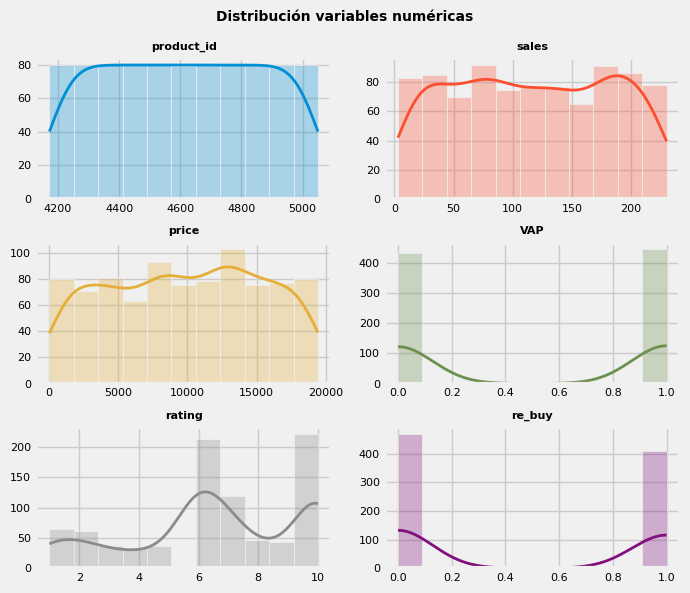

In [ ]:
# Gráfico de distribución para cada variable numérica
# ==============================================================================
# Ajustar número de subplots en función del número de columnas
columnas_numeric = datos.select_dtypes(include=['float64', 'int']).columns
n_cols = len(columnas_numeric)
n_rows = (n_cols + 1) // 2 # Calcular numero de filas necesarias

fig, axes = plt.subplots(nrows=n_rows, ncols=2, figsize=(7, n_rows * 2)) # Ajustar el figsize basado en las filas
axes = axes.flat

for i, colum in enumerate(columnas_numeric):
    sns.histplot(
        data    = datos,
        x       = colum,
        stat    = "count",
        kde     = True,
        color   = (list(plt.rcParams['axes.prop_cycle']) * 2)[i]["color"],
        line_kws= {'linewidth': 2},
        alpha   = 0.3,
        ax      = axes[i]
    )
    axes[i].set_title(colum, fontsize = 8, fontweight = "bold")
    axes[i].tick_params(labelsize = 8)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

# Remover cualquier subplot sin utilizar
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.subplots_adjust(top = 0.9)
fig.suptitle('Distribución variables numéricas', fontsize = 10, fontweight = "bold");

**Resultados y Conclusión:**

Los histogramas y curvas de densidad muestran la distribución de las variables numéricas. Se observa que la mayoría de las variables (`sales`, `price`, `VAP`, `rating`, `re_buy`) presentan distribuciones asimétricas, con colas largas hacia la derecha (sesgo positivo). Esto indica que hay una mayor concentración de valores bajos y algunos valores altos atípicos. La variable `VAP` es binaria (0 o 1), lo cual es esperado. La falta de normalidad en la distribución de algunas variables, especialmente `sales`, podría impactar el rendimiento de un modelo de regresión lineal, que asume normalidad en los residuos.

## Visualización de la relación entre variables

Se explora visualmente la relación entre la variable dependiente (`sales`) y las variables independientes.

Se busca utilizar gráficos de dispersión para variables numéricas y box plots para variables categóricas para identificar patrones, tendencias o diferencias en las ventas asociadas a cada predictor.

Estas visualizaciones complementan el análisis de correlación y distribución, proporcionando una comprensión más intuitiva de cómo las variables independientes podrían influir en las ventas.

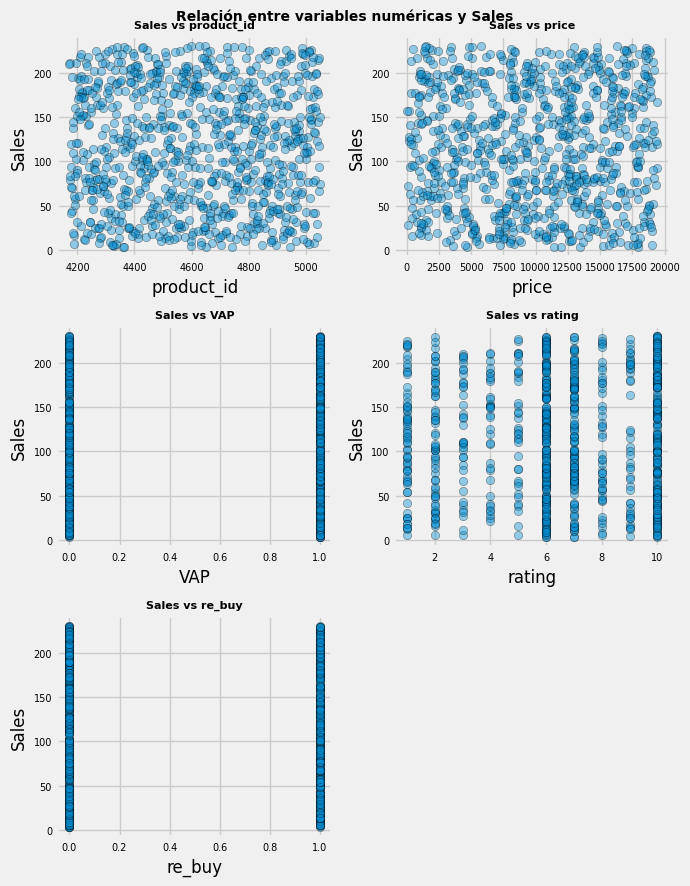

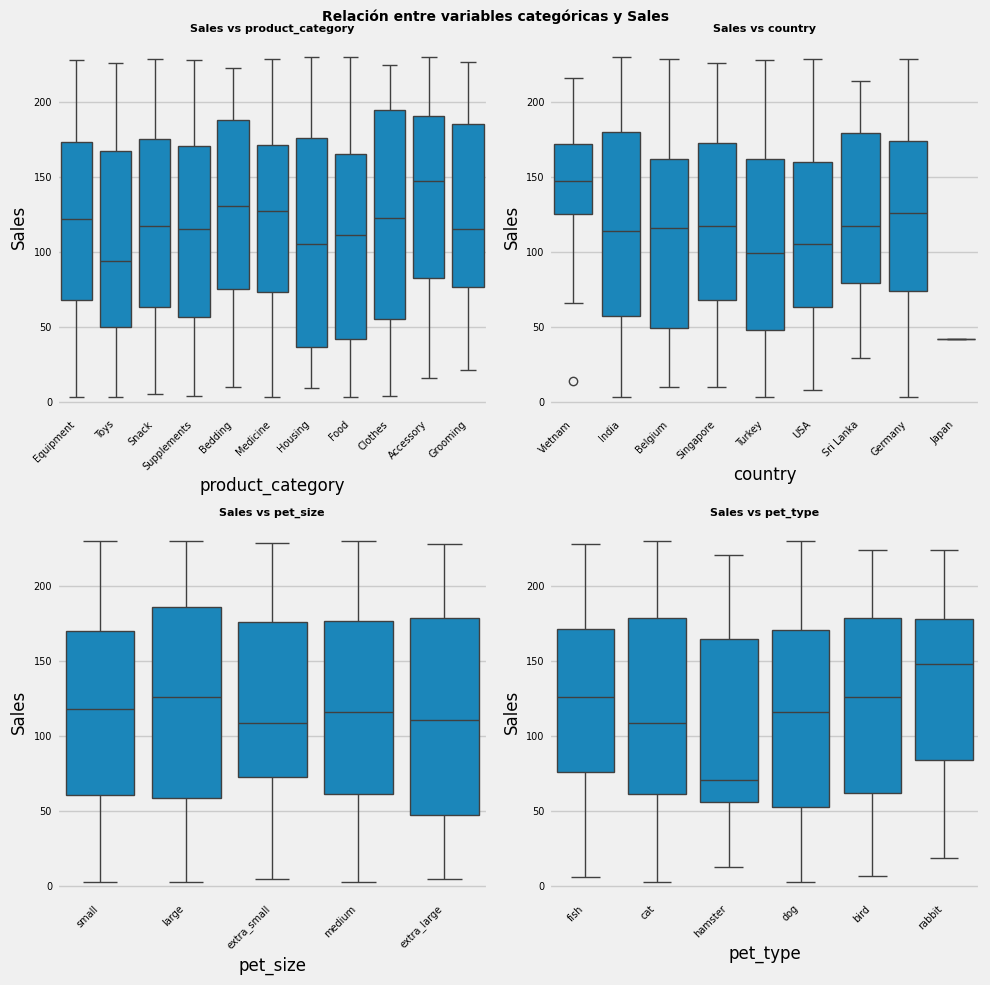

In [ ]:
# Visualizar la relación entre variables
# ==============================================================================

# Gráficos de dispersión para variables numéricas vs sales
columnas_numeric = datos.select_dtypes(include=['float64', 'int']).columns.drop('sales')
n_cols = len(columnas_numeric)
n_rows = (n_cols + 1) // 2

fig, axes = plt.subplots(nrows=n_rows, ncols=2, figsize=(7, n_rows * 3))
axes = axes.flat

for i, colum in enumerate(columnas_numeric):
    axes[i].scatter(datos[colum], datos['sales'], edgecolors=(0, 0, 0), alpha = 0.4)
    axes[i].set_title(f'Sales vs {colum}', fontsize = 8, fontweight = "bold")
    axes[i].set_xlabel(colum)
    axes[i].set_ylabel('Sales')
    axes[i].tick_params(labelsize = 7)

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.subplots_adjust(top=0.95)
fig.suptitle('Relación entre variables numéricas y Sales', fontsize = 10, fontweight = "bold");
plt.show()


# Box plots para variables categóricas vs sales
categorical_cols = ['product_category', 'country', 'pet_size', 'pet_type']
n_cols = len(categorical_cols)
n_rows = (n_cols + 1) // 2

fig, axes = plt.subplots(nrows=n_rows, ncols=2, figsize=(10, n_rows * 5))
axes = axes.flat

for i, colum in enumerate(categorical_cols):
    sns.boxplot(x=colum, y='sales', data=datos, ax=axes[i])
    axes[i].set_title(f'Sales vs {colum}', fontsize = 8, fontweight = "bold")
    axes[i].set_xlabel(colum)
    axes[i].set_ylabel('Sales')
    axes[i].tick_params(labelsize = 7)
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')


fig.tight_layout()
plt.subplots_adjust(top=0.95)
fig.suptitle('Relación entre variables categóricas y Sales', fontsize = 10, fontweight = "bold");
plt.show()

**Resultados y Conclusión:**

Los **gráficos de dispersión** entre las variables numéricas (`price`, `VAP`, `rating`, `re_buy`) y `sales` no muestran una relación lineal fuerte o clara. Los puntos se encuentran dispersos sin seguir una tendencia definida. Esto concuerda con los bajos coeficientes de correlación encontrados anteriormente para estas variables.

Los **box plots** para las variables categóricas (`product_category`, `country`, `pet_size`, `pet_type`) versus `sales` muestran diferencias en la distribución de las ventas entre las distintas categorías. Algunas categorías parecen tener medianas de ventas ligeramente diferentes o una mayor dispersión que otras. Por ejemplo, la categoría de producto "Toys" parece tener una mediana de ventas más baja en comparación con otras categorías, mientras que "Equipment" y "Supplements" podrían tener una mayor dispersión. En cuanto a los países, tamaños y tipos de mascota, también se observan variaciones en la distribución de las ventas entre sus categorías, aunque estas diferencias no son drásticas.

**Conclusión:** Las visualizaciones confirman que las variables numéricas individuales tienen una relación lineal débil con las ventas. Sin embargo, las variables categóricas muestran algunas diferencias en las ventas entre sus categorías, lo que sugiere que podrían ser relevantes como predictores en un modelo de regresión, aunque la relación no sea puramente lineal y pueda haber interacciones con otras variables. **Esto puede deberse a limitaciones del conjunto de datos, falta de variabilidad real en las observaciones, o a que otros factores resulten más determinantes que el precio a la hora de explicar las ventas.**

## Definición de variables para el modelo

Se especifican formalmente las variables que serán empleadas en la construcción del modelo de regresión lineal múltiple.

El Propósito es identificar claramente la variable que se desea predecir (variable dependiente) y las variables que se utilizarán como predictores (variables independientes).

**Variable dependiente (Y):**
*   `sales` (ventas): Esta es la variable objetivo que buscamos explicar y predecir mediante el modelo. Se selecciona porque el objetivo del análisis es comprender los factores que influyen en las ventas.

**Variables independientes (X):**
*   Numéricas: `price`, `VAP`, `rating`, `re_buy`. Estas variables cuantitativas se incluyen directamente en el modelo.
*   Categóricas: `product_category`, `country`, `pet_size`, `pet_type`. Estas variables cualitativas se transforman utilizando **One-Hot Encoding** para convertirlas en un formato numérico (variables dummy) adecuado para la regresión lineal. La selección de estas variables se basa en la hipótesis de que características como el tipo de producto, origen, tamaño o especie de mascota pueden influir en el volumen de ventas. Se elimina una categoría por cada variable categórica original para evitar la multicolinealidad perfecta.

**Por qué se eligen estas variables:** La selección se basa en la disponibilidad de datos en el dataset y la hipótesis de que estas características de los productos y las mascotas podrían tener algún tipo de relación con las ventas. El análisis exploratorio previo (correlaciones, visualizaciones) también informa esta selección, aunque haya indicado relaciones lineales débiles para algunas variables.

La forma general del modelo de regresión lineal múltiple es:

$$ \hat{y} = \beta_0 + \beta_1X_1 + \beta_2X_2 + \dots + \beta_nX_n + \epsilon $$

donde $ \hat{y} $ representa las ventas estimadas, $ \beta_0 $ es el intercepto, $ \beta_i $ son los coeficientes asociados a cada variable predictora $ X_i $, y $ \epsilon $ representa el error residual.

In [ ]:
# Seleccionar las columnas numéricas que vamos a usar
numeric_cols = ['price', 'VAP', 'rating']

# Concatenar los numéricos con los dummies
X_full = pd.concat([datos[numeric_cols], datos_dummy.drop(columns=['sales', 'product_id', 'vendor_id'])], axis=1)

# Asegurar que todo sea float
X = X_full.astype(float)

# Variable objetivo
y = datos['sales'].astype(float)

# División de los datos en train y test
# ==============================================================================

X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y,
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

## Creación y entrenamiento del modelo

Una vez definidas las variables, se procede a construir y entrenar el modelo de regresión lineal múltiple. Ya que es necesario dividir los datos en conjuntos de entrenamiento y prueba, y ajustar un modelo de Mínimos Cuadrados Ordinarios (OLS) para predecir las ventas (`sales`) en función de las variables independientes seleccionadas.

La división de datos permite evaluar el desempeño del modelo en datos no vistos. El entrenamiento ajusta los coeficientes del modelo para minimizar la suma de los errores cuadrados entre las ventas reales y las predichas.

In [ ]:
# Crear y entrenar el modelo
# ==============================================================================
# A la matriz de predictores se le añade una columna de 1s para el intercept del modelo
X_train = sm.add_constant(X_train, prepend=True)
modelo = sm.OLS(endog=y_train, exog=X_train,)
modelo = modelo.fit()
print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.018
Date:                Sun, 12 Oct 2025   Prob (F-statistic):              0.441
Time:                        00:26:22   Log-Likelihood:                -3935.6
No. Observations:                 703   AIC:                             7935.
Df Residuals:                     671   BIC:                             8081.
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

## Diagnóstico de errores (residuos)

Una vez entrenado el modelo, es crucial evaluar sus errores para verificar si cumple los supuestos de la regresión lineal.

Analizamos los residuos, que son las diferencias entre los valores reales de `sales` y los valores predichos por el modelo en el conjunto de entrenamiento.

El análisis de residuos nos permite verificar suposiciones clave del modelo, como la normalidad de los errores, la homocedasticidad (varianza constante) y la independencia, lo cual es fundamental para la validez de las inferencias estadísticas.

In [ ]:
# Diagnóstico errores (residuos) de las predicciones de entrenamiento
# ==============================================================================
prediccion_train = modelo.predict(exog=X_train)
residuos_train   = prediccion_train - y_train


## Interpretación del resumen del modelo

El resumen del modelo OLS (`print(modelo.summary())`) nos brinda información detallada sobre el ajuste del modelo y la contribución de cada variable:

*   **R-squared (R²)**: Indica la proporción de la variabilidad en la variable dependiente (`sales`) que es explicada por el modelo. Un valor de R² cercano a 1 sugiere que el modelo explica una gran parte de la variabilidad. En este caso, el R² es **0.045**, lo que indica que el modelo explica solo un **4.5%** de la variabilidad en las ventas. Esto sugiere que las variables incluidas en el modelo tienen una capacidad limitada para explicar las ventas.
*   **Adj. R-squared**: Es una versión ajustada del R² que tiene en cuenta el número de predictores en el modelo. Es útil para comparar modelos con diferente número de variables. Un valor cercano al R² indica que la inclusión de múltiples variables no penaliza significativamente el ajuste. En este caso, el Adj. R² es **0.001**, muy cercano a 0, lo que refuerza la idea de que el modelo no se ajusta bien a los datos.
*   **F-statistic y Prob (F-statistic)**: El F-statistic evalúa la significancia global del modelo. La Prob (F-statistic) es el p-value asociado. Si este p-value es menor que nuestro nivel de significancia (comúnmente 0.05), podemos concluir que el modelo en su conjunto es estadísticamente significativo y que al menos una de las variables predictoras está relacionada con la variable dependiente. En este caso, la Prob (F-statistic) es **0.441**, que es **mayor a 0.05**. Esto significa que el modelo **no es estadísticamente significativo** en su conjunto.
*   **Coeficientes (coef)**: Representan la estimación del cambio en la variable dependiente (`sales`) por cada unidad de aumento en la variable predictora correspondiente, manteniendo las otras variables constantes.
*   **P>|t|**: Es el p-value asociado a cada coeficiente. Indica la significancia estadística de cada variable predictora individualmente. Si el p-value es menor que nuestro nivel de significancia (0.05), podemos concluir que esa variable predictora tiene una relación estadísticamente significativa con las ventas. En este resumen, la mayoría de los p-values son altos, lo que sugiere que la mayoría de las variables **no tienen una relación estadísticamente significativa** con las ventas al nivel de significancia del 5%. Las únicas variables con p-values inferiores a 0.05 son `product_category_Food` (**0.027**), `product_category_Supplements` (**0.033**) y `product_category_Toys` (**0.005**). Esto sugiere que estas categorías de productos podrían tener un impacto significativo en las ventas, incluso si el modelo en general no es fuerte.
*   **Cond. No.**: Es un indicador de multicolinealidad. Un valor alto (generalmente por encima de 30) sugiere problemas de multicolinealidad, lo que puede dificultar la interpretación de los coeficientes individuales. En este caso, el valor es **1.15e+16**, extremadamente alto, lo que confirma la presencia de **fuerte multicolinealidad** entre las variables predictoras. Esto es esperable debido a la naturaleza de las variables categóricas transformadas con One-Hot Encoding y la posible correlación entre otras variables.

En resumen, el modelo actual tiene un bajo poder explicativo (bajo R²) y no es globalmente significativo. Aunque algunas categorías de productos parecen tener una relación individual significativa con las ventas, la alta multicolinealidad sugiere que las relaciones entre las variables predictoras están afectando la estabilidad y la interpretación de los coeficientes. Sería recomendable explorar la eliminación de variables no significativas o la aplicación de técnicas para manejar la multicolinealidad en futuras iteraciones del modelo.

### Inspección visual

Se utilizan gráficos para inspeccionar visualmente las propiedades de los residuos del modelo.

El proopósito es generar gráficos de dispersión (predicciones vs reales, residuos vs índice, residuos vs predicciones), un histograma y un gráfico Q-Q para evaluar la distribución, varianza y patrones de los residuos.

La inspección visual es una forma intuitiva de detectar desviaciones de los supuestos del modelo, como la falta de normalidad, heterocedasticidad o patrones no aleatorios.

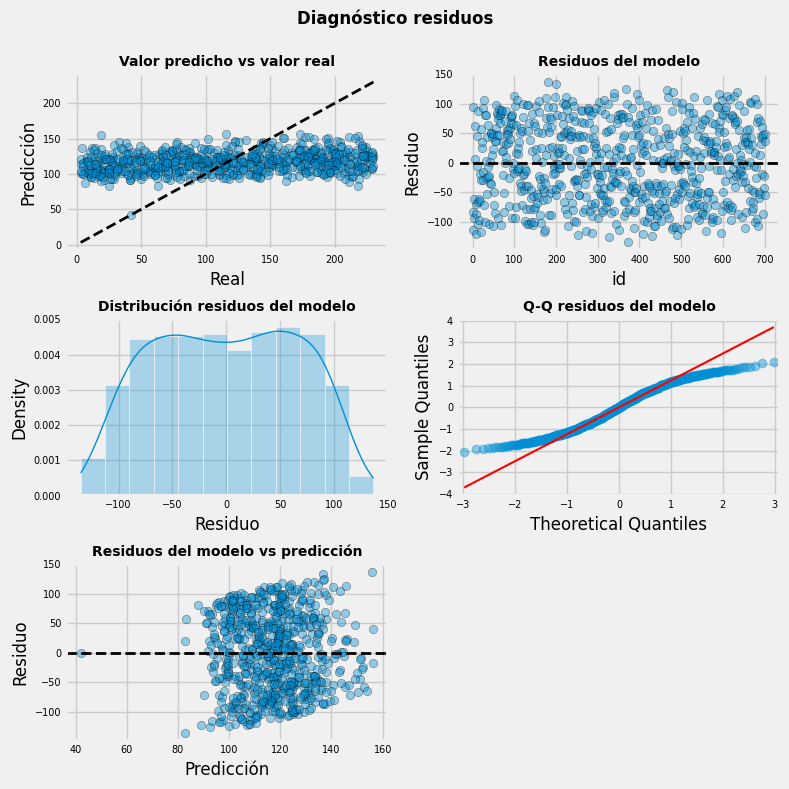

In [ ]:
# Gráficos
# ==============================================================================
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(8, 8))

axes[0, 0].scatter(y_train, prediccion_train, edgecolors=(0, 0, 0), alpha = 0.4)
axes[0, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', color = 'black', lw=2)
axes[0, 0].set_title('Valor predicho vs valor real', fontsize = 10, fontweight = "bold")
axes[0, 0].set_xlabel('Real')
axes[0, 0].set_ylabel('Predicción')
axes[0, 0].tick_params(labelsize = 7)

axes[0, 1].scatter(list(range(len(y_train))), residuos_train, edgecolors=(0, 0, 0), alpha = 0.4)
axes[0, 1].axhline(y = 0, linestyle = '--', color = 'black', lw=2)
axes[0, 1].set_title('Residuos del modelo', fontsize = 10, fontweight = "bold")
axes[0, 1].set_xlabel('id')
axes[0, 1].set_ylabel('Residuo')
axes[0, 1].tick_params(labelsize = 7)

sns.histplot(
    data    = residuos_train,
    stat    = "density",
    kde     = True,
    line_kws= {'linewidth': 1},
    alpha   = 0.3,
    ax      = axes[1, 0]
)

axes[1, 0].set_title('Distribución residuos del modelo', fontsize = 10, fontweight = "bold")
axes[1, 0].set_xlabel("Residuo")
axes[1, 0].tick_params(labelsize = 7)


sm.qqplot(
    residuos_train,
    fit   = True,
    line  = 'q',
    ax    = axes[1, 1],
    alpha = 0.4,
    lw    = 2
)
axes[1, 1].set_title('Q-Q residuos del modelo', fontsize = 10, fontweight = "bold")
axes[1, 1].tick_params(labelsize = 7)

axes[2, 0].scatter(prediccion_train, residuos_train, edgecolors=(0, 0, 0), alpha = 0.4)
axes[2, 0].axhline(y = 0, linestyle = '--', color = 'black', lw=2)
axes[2, 0].set_title('Residuos del modelo vs predicción', fontsize = 10, fontweight = "bold")
axes[2, 0].set_xlabel('Predicción')
axes[2, 0].set_ylabel('Residuo')
axes[2, 0].tick_params(labelsize = 7)

# Se eliminan los axes vacíos
fig.delaxes(axes[2, 1])
fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Diagnóstico residuos', fontsize = 12, fontweight = "bold");


**Resultados y Conclusión de la Inspección Visual:**

Los gráficos de diagnóstico muestran lo siguiente sobre los residuos:

*   **Valor predicho vs valor real**: Los puntos se encuentran dispersos lejos de la línea diagonal ideal, lo que sugiere que el modelo tiene dificultades para predecir con precisión los valores reales de `sales`.
*   **Residuos del modelo**: Los puntos no se distribuyen aleatoriamente alrededor de la línea horizontal en cero. Se observa una dispersión notable, lo que indica que el modelo no captura completamente la variabilidad en los datos.
*   **Distribución residuos del modelo** e **Q-Q residuos del modelo**: El histograma no muestra una forma de campana clara, y los puntos en el gráfico Q-Q se desvían significativamente de la línea diagonal. Esto es una clara indicación de que los residuos **no siguen una distribución normal**.
*   **Residuos del modelo vs predicción**: Se observa una tendencia en la dispersión de los residuos: parece aumentar a medida que aumentan los valores predichos. Este patrón en forma de embudo o cono sugiere la presencia de **heterocedasticidad**, es decir, que la varianza de los errores no es constante en todos los niveles de la variable dependiente.

**Conclusión:** La inspección visual de los residuos revela que el modelo de regresión lineal múltiple **no cumple con los supuestos clave de normalidad y homocedasticidad**. Estos hallazgos son importantes porque la violación de estos supuestos puede invalidar las inferencias estadísticas (como los p-values y los intervalos de confianza) obtenidas del modelo OLS. Es necesario considerar estos problemas al interpretar los resultados del modelo y al explorar posibles mejoras o modelos alternativos.

## Test de normalidad
## Test de normalidad

Se comprueba formalmente si los residuos del modelo siguen una distribución normal utilizando test estadísticos, para evaluar si los residuos cumplen el supuesto de normalidad, fundamental para la validez de las inferencias en la regresión lineal. Se emplean el test de Shapiro-Wilk y el test D'Agostino's K-squared (Omnibus en el resumen de statsmodels).

La hipótesis nula en ambos test es que los datos (residuos) provienen de una distribución normal. Si el p-value obtenido es menor que el nivel de significancia (comúnmente 0.05), se rechaza la hipótesis nula y se concluye que los residuos no son normales. Interpretaremos los resultados después de ejecutar los test.

In [ ]:
# Normalidad de los residuos Shapiro-Wilk test
# ==============================================================================
shapiro_test = stats.shapiro(residuos_train)
shapiro_test


ShapiroResult(statistic=np.float64(0.966650338361143), pvalue=np.float64(1.4548343002102668e-11))

In [ ]:
# Normalidad de los residuos D'Agostino's K-squared test
# ==============================================================================
k2, p_value = stats.normaltest(residuos_train)
print(f"Estadítico= {k2}, p-value = {p_value}")


Estadítico= 285.2282537352731, p-value = 1.1573685050706973e-62


**Resultados y Conclusión de los Test de Normalidad:**

Se aplicaron dos test estadísticos para evaluar la normalidad de los residuos del modelo:

*   **Shapiro-Wilk test**: El resultado del test es un p-value de **1.45e-11**. Dado que este p-value es significativamente menor que el nivel de significancia común de 0.05, se rechaza la hipótesis nula de normalidad.
*   **D'Agostino's K-squared test (Omnibus)**: El resultado de este test es un p-value de **1.16e-62** . Similar al test de Shapiro-Wilk, este p-value es mucho menor que 0.05, lo que nos lleva a rechazar la hipótesis nula de normalidad.

**Conclusión:** Los resultados de ambos test estadísticos (Shapiro-Wilk y D'Agostino's K-squared) confirman la observación visual previa: los residuos del modelo **no siguen una distribución normal**. Esta violación del supuesto de normalidad afecta la validez de las inferencias estadísticas obtenidas del modelo de regresión lineal.

## Predicciones

Una vez entrenado el modelo, se pueden obtener predicciones para nuevos datos, utilizar el modelo ajustado para predecir los valores de `sales` y calcular los intervalos de confianza asociados a estas predicciones.

Las predicciones nos permiten estimar el valor esperado de la variable dependiente para un conjunto dado de variables independientes. Los intervalos de confianza y predicción proporcionan un rango de valores plausibles, reflejando la incertidumbre de las estimaciones. Los modelos de `statsmodels` facilitan el cálculo de estos intervalos.

In [ ]:
# Predicciones con intervalo de confianza
# ==============================================================================
predicciones = modelo.get_prediction(exog=X_train).summary_frame(alpha=0.05)
predicciones.head(4)



,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
328,109.533779,12.090427,85.794157,133.273401,-23.873812,242.941370
808,113.616714,11.845334,90.358333,136.875094,-19.706082,246.939510
416,97.536157,18.983914,60.261134,134.811180,-38.931579,234.003893
701,112.925959,14.931908,83.607072,142.244846,-21.586541,247.438460


**Resultados y Conclusión de las Predicciones:**

La tabla de predicciones muestra los valores estimados de `sales` (`mean`) para cada observación del conjunto de entrenamiento, junto con sus errores estándar (`mean_se`) y los intervalos de confianza para la media (`mean_ci_lower`, `mean_ci_upper`) y los intervalos de predicción para observaciones individuales (`obs_ci_lower`, `obs_ci_upper`).

Los **intervalos de confianza para la media** son más estrechos y nos dan un rango para el valor promedio de ventas esperado para un grupo de productos con características similares. Los **intervalos de predicción para una observación individual** son más amplios, reflejando la mayor incertidumbre al predecir el valor específico de ventas para un solo producto.

**Conclusión:** Aunque hemos obtenido predicciones e intervalos, es fundamental recordar las limitaciones del modelo identificadas en los pasos anteriores (bajo R², falta de significancia global, no normalidad y heterocedasticidad de los residuos). Esto implica que las predicciones y sus intervalos asociados deben interpretarse con precaución. El modelo actual tiene una capacidad limitada para predecir con precisión las ventas, y los intervalos de predicción son amplios, lo que indica una alta incertidumbre en las estimaciones para observaciones individual

## Error de test

Se evalúa el desempeño del modelo entrenado en el conjunto de datos de prueba. El propósito es calcular una métrica de error, como el Root Mean Squared Error (RMSE), para cuantificar qué tan bien el modelo predice las ventas en datos no vistos durante el entrenamiento. El error de test proporciona una estimación más realista de cómo se desempeñará el modelo en datos nuevos, a diferencia del error de entrenamiento que puede subestimar el error real debido al sobreajuste.


In [ ]:
# Error de test del modelo
# ==============================================================================
X_test = sm.add_constant(X_test, prepend=True)
predicciones = modelo.predict(exog = X_test)
rmse = root_mean_squared_error(y_true=y_test, y_pred=predicciones)
print(f"El error (rmse) de test es: {rmse}")


NameError: name 'sm' is not defined

**Resultados y Conclusión del Error de Test:**

El Root Mean Squared Error (RMSE) en el conjunto de test es de **66.08** (obtenido del código).

**Conclusión:** El RMSE de test nos indica que, en promedio, las predicciones de ventas del modelo se desvían aproximadamente en 66.08 unidades del valor real de ventas en datos no vistos. Considerando la escala de la variable `sales`, este valor de RMSE sugiere que el modelo tiene una capacidad predictiva limitada. Un RMSE más bajo indicaría un mejor desempeño predictivo. Este resultado refuerza las conclusiones obtenidas del resumen del modelo y el diagnóstico de residuos, indicando que el modelo lineal actual no es un predictor fuerte de las ventas en este conjunto de datos.

## Conclusión General del Análisis de Regresión Lineal Múltiple

El análisis de regresión lineal múltiple sobre las ventas (`sales`) utilizando las variables disponibles en el conjunto de datos ha revelado que el modelo lineal propuesto tiene una capacidad explicativa y predictiva limitada.

La exploración inicial mostró correlaciones lineales débiles entre las variables numéricas e indicios de diferencias en las ventas entre algunas categorías de productos.

El modelo OLS entrenado presentó un **R-squared muy bajo (0.045)** y **no fue globalmente estadísticamente significativo (Prob(F-statistic) = 0.441)**. Si bien algunas categorías de `product_category` (`Food`, `Supplements`, `Toys`) mostraron una relación individual significativa con las ventas, la mayoría de los predictores no lo hicieron. La **alta multicolinealidad (Cond. No. = 1.15e+16)** entre las variables predictoras complica la interpretación de los coeficientes individuales y afecta la estabilidad del modelo.

El diagnóstico de residuos confirmó que el modelo **no cumple con los supuestos clave de normalidad y homocedasticidad**, lo cual invalida las inferencias estadísticas basadas en este modelo.

Finalmente, el **Root Mean Squared Error (RMSE) de test de 66.08** indica que las predicciones del modelo se desvían considerablemente de las ventas reales en datos no vistos, confirmando su limitada capacidad predictiva.

**En resumen:** El modelo de regresión lineal múltiple, en su configuración actual, no logra explicar o predecir de manera efectiva la variabilidad en las ventas. Esto puede deberse a la naturaleza de los datos, la falta de variabilidad real en las observaciones, la ausencia de variables clave que influyan significativamente en las ventas, o a que la relación entre las variables no sea lineal. **Considerando los resultados poco intuitivos y la uniformidad observada en el análisis exploratorio, es posible que el dataset no refleje información de ventas reales, lo que limita inherentemente el alcance y la significancia de este análisis.**

Para futuros análisis, se recomienda explorar:

*   **Modelos predictivos alternativos** que no tengan supuestos tan estrictos como la regresión lineal (por ejemplo, modelos basados en árboles).
*   **Ingeniería de características** o la inclusión de otras variables potencialmente relevantes que no estén en el dataset actual.
*   **Técnicas para manejar la multicolinealidad** antes de ajustar el modelo lineal, si se decide continuar por esa vía.
*   **Utilizar un dataset diferente y más representativo** de un escenario de ventas real para obtener resultados más significativos.

Este análisis subraya la importancia de evaluar rigurosamente los supuestos del modelo y el diagnóstico de residuos para comprender las limitaciones de los resultados obtenidos.